# Mixture Density Network

This notebook trains a simple gaussian mixture density network from basic statistics of the predictive distributions coming from the component models.

In [63]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("../src")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import data
import utils
import losses

from functools import partial, reduce

from keras.layers import (Activation, Dense, Dropout, Embedding, Flatten, Merge, Reshape)
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import keras.backend as K
from sklearn.model_selection import train_test_split
from scipy.stats import norm

## Load data

In [65]:
class Component:
    """
    Helper class for working with components
    """
    
    def __init__(self, name):
        self.name = name
        self.loader = data.ComponentDataLoader("../data", name)

In [66]:
components = [Component(name) for name in [
    "kcde",
    "kde",
    "sarima"
]]
actual_dl = data.ActualDataLoader("../data")

### Working on week ahead predictions

We need to take the common row entries (common "epiweek", "region") for each data item, i.e. actual data and component data.

In [67]:
REGION = None # Specify None for using all the data
WEEK_NUMBER = 1

y, Xs, yi = data.get_week_ahead_training_data(
    WEEK_NUMBER, REGION,
    actual_dl, [cmp.loader for cmp in components]
)

for idx, cmp in enumerate(components):
    cmp.data = Xs[idx]

### Extracting statistical features from the distributions

We are just using the mean and std of distributions and concatenating to a single vector as input to the model.

*X* refers to combined features from all the models.

*X_[model]* refers to full distributions from a particular model.

In [68]:
X = utils.get_merged_features(
    Xs, 
    [utils.dist_mean, utils.dist_std]
)

### Split based on year
We take items before epiweek *201443* as train and rest as test

In [70]:
train_indices = yi[:, 0] < 201443

## Model

The model is a simple mixture density network which returns a set of parameters which are then used in the loss function to get the negative log score for optimization

In [71]:
def mdn(n_input, n_mix):
    """
    Return a mixture density model with given number of mixtures (gaussians)
    """
    
    model = Sequential()
    model.add(Dense(20, input_shape=(n_input,)))
    model.add(Activation("relu"))
    model.add(Dense(10))
#     model.add(Activation("relu"))
#     model.add(Dense(5))
    model.add(Activation("relu"))
    model.add(Dense(5))
    model.add(Activation("relu"))
    
    # Return 3 parameters, mu, sigma and mixture weight
    model.add(Dense(n_mix * 3))
    
    return model

In [72]:
N_MIX = 2
loss_fn = partial(losses.mdn_loss, n_mix=N_MIX)
loss_fn.__name__ = "mdn_loss" # Keras needs a name for function

### Training

In [81]:
# model generator
def gen_model():
    return mdn(X.shape[1], N_MIX)

def train_model(model, train_data, val_data):
    model.compile(optimizer="rmsprop", loss=loss_fn)

    early_stop = EarlyStopping(monitor="val_loss", patience=4, mode="auto")

    history = model.fit(train_data[0],
                        train_data[1],
                        batch_size=64, epochs=100,
                        verbose=0,
                        callbacks=[early_stop],
                        validation_data=val_data)
    return history

In [82]:
[model, mean_losses, cv_metadata, final_history] = utils.cv_train_loso(
    gen_model, train_model,
    X[train_indices], y[train_indices], yi[train_indices]
)

  0%|          | 0/17 [00:00<?, ?it/s]

Total 17 found.


100%|██████████| 17/17 [01:03<00:00,  3.95s/it]
/home/lepisma/.local/share/virtualenvs/neural-stack-cX3QmLJO/lib/python3.6/site-packages/keras/callbacks.py:496: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


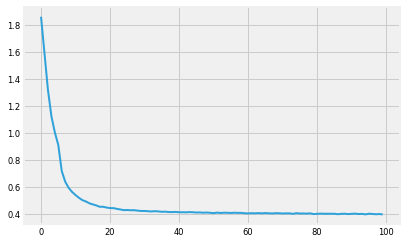

In [83]:
plt.plot(final_history.history["loss"])

### Evaluation

In [100]:
regions = ["nat", *[f"hhs{i}" for i in range(1, 11)], None]

mdls = [*[cmp.name for cmp in components], "n-ensemble",
        "ave-ensemble", "prod-ensemble"]

eval_df = {mdl: [] for mdl in mdls}

def cat_cross(y_pred, y_true):
    return np.mean(-np.log(np.multiply(y_pred, y_true).sum(axis=1) + K.epsilon()))

for region in regions:
    if region is None:
        eval_indices = ~train_indices
    else:
        eval_indices = (~train_indices) & (yi[:, 1] == region)
        
    component_dists = [cmp.data[eval_indices] for cmp in components]
    n_dist = utils.mdn_params_to_dists(model.predict(X[eval_indices]))
    ave_dist = np.mean(component_dists, axis=0)
    
    prod_dist = reduce(np.multiply, component_dists)
    prod_dist /= prod_dist.sum(axis=1, keepdims=True) + K.epsilon()

    dists = [
        *component_dists,
        n_dist,
        ave_dist,
        prod_dist
    ]
    y_one_hot = utils.wili_to_dists(y[eval_indices])
    
    for name, output in zip(mdls, dists):
        eval_df[name].append(cat_cross(output, y_one_hot))
eval_df = pd.DataFrame(eval_df)
eval_df.index = [*regions[:-1], "All"]
eval_df.to_csv(f"{WEEK_NUMBER}_eval.csv")

In [101]:
eval_df

,ave-ensemble,kcde,kde,n-ensemble,prod-ensemble,sarima
nat,2.581708,2.405234,3.423345,2.296350,2.259235,2.399479
hhs1,2.832407,2.503327,3.579158,2.235179,2.448335,2.780681
hhs2,3.314429,3.090899,3.822924,2.829045,2.988846,3.224743
hhs3,3.098326,2.830262,3.492511,2.679466,2.697548,3.167912
hhs4,2.823580,2.765214,3.608841,2.477638,2.671554,2.606800
hhs5,2.757950,2.562790,3.549449,2.352887,2.446822,2.677093
hhs6,3.922481,3.570313,4.714815,3.431386,3.718679,3.853882
hhs7,3.004194,2.843841,3.606729,2.532609,2.786142,2.847026
hhs8,2.893882,2.618961,3.441011,2.286748,2.532224,2.833455
hhs9,3.193004,2.907273,3.711663,2.684957,2.654017,3.168343


## Plot random predictions

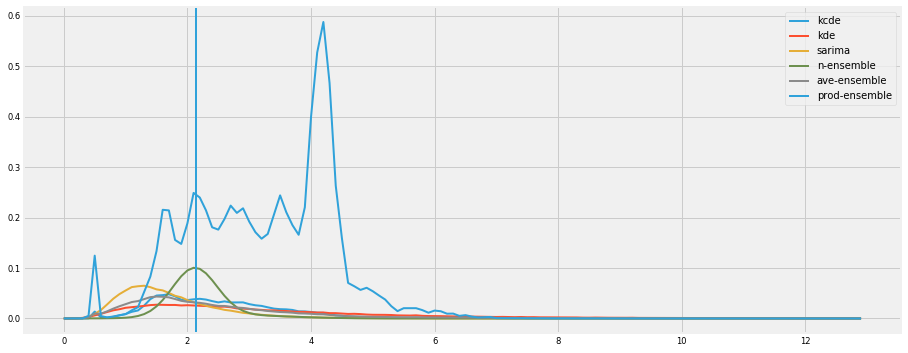

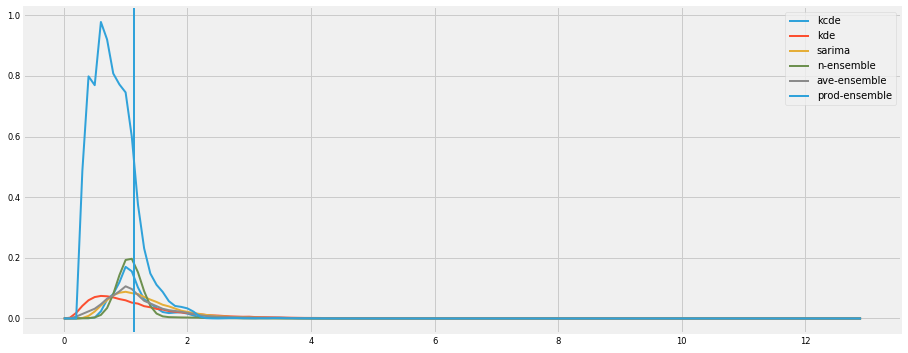

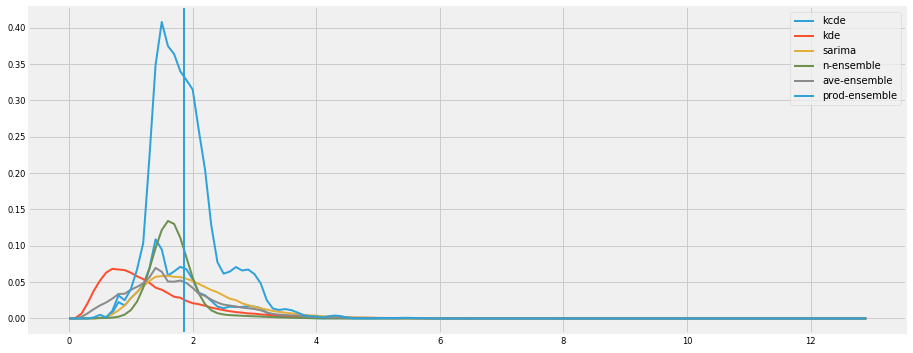

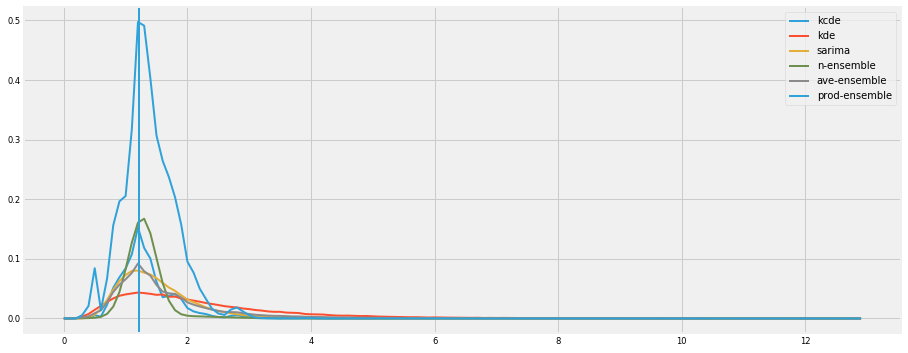

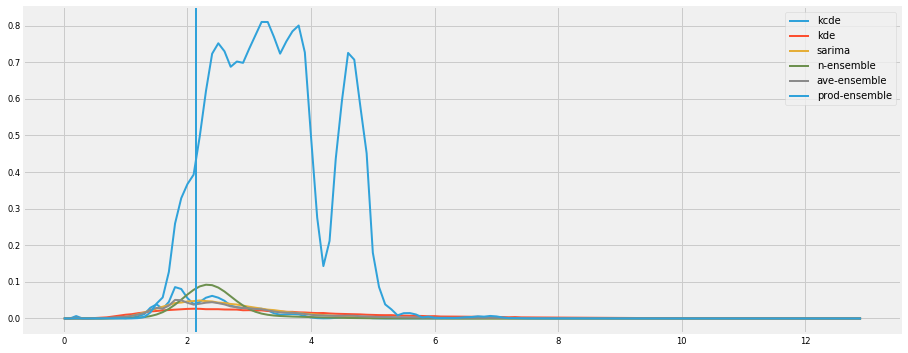

In [80]:
# Sample few of the examples
n_plots = 5
plot_indices = np.random.randint(0, y[~train_indices].shape[0], size=n_plots)

y_plot_out = y[~train_indices][plot_indices]

component_dists = [cmp.data[~train_indices][plot_indices] for cmp in components]

n_dist = utils.mdn_params_to_dists(model.predict(X[~train_indices][plot_indices]))
ave_dist = np.mean(component_dists, axis=0)
prod_dist = reduce(np.multiply, component_dists)
prod_dist /= prod_dist.sum(axis=0) + K.epsilon()

dists = [*component_dists, n_dist, ave_dist, prod_dist]

bins = np.linspace(0, 12.9, 130)
mdls = [*[cmp.name for cmp in components], "n-ensemble", "ave-ensemble", "prod-ensemble"]

for pidx in range(n_plots):
    plt.figure(figsize=(14, 6))
    for idx, mdl in enumerate(mdls):
        plt.plot(bins, dists[idx][pidx], label=mdl)
    
    # Plot actual line
    plt.axvline(x=y_plot_out[pidx])
    
    plt.legend()